# Notes
Regression model to directly predict returns

In [1]:
# import libraries
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)
import os
from os.path import isfile, isdir, join
import numpy as np
import pandas as pd
from datetime import datetime, date
from dateutil.relativedelta import relativedelta
from bs4 import BeautifulSoup
import re
from IPython.display import display
from zipfile import ZipFile
import pickle
import unicodedata
import pytz
from joblib import Parallel, delayed
import shutil
import difflib
import random
import math
from shutil import copyfile
import itertools
import time
from tqdm import tqdm
import collections
from collections import deque
import gc

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import ndcg_score, accuracy_score, mean_squared_error

import lightgbm as lgbm
import optuna
from optuna import Trial, visualization

import matplotlib as mpl
from matplotlib import pyplot as plt

import jpx_tokyo_market_prediction

from utility_script import *

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

In [2]:
'''
Notebook Parameters
'''
SEED = 0
N_STOCK_SAMPLE = 2000
N_DAY_SAMPLE = 300
N_FOLD = 5
STOCK_LIST = pd.read_csv('../input/jpx-tokyo-stock-exchange-prediction/stock_list.csv').loc[lambda x: x.Universe0==1].SecuritiesCode.sort_values().unique().tolist()[:N_STOCK_SAMPLE]
LAGS = {'1d':1, '3d':3, '1w':5, '1m':20, '3m':20*3, '6m':20*6, '12m':20*12}
MAX_DAYS_LAG = max(list(LAGS.values()))
WIN_SIZE = 500
JPX_PATH = '../input/jpx-tokyo-stock-exchange-prediction'
TRN_SIZE = 240
VAL_SIZE = 60
TRN_VAL_GAP = 14
EVAL_METRIC = 'rmse'
DEVICE_TYPE = 'CPU'
EARLY_STOPPING_ROUNDS = 30
SELECTED_FEATS = 'sec_cross_sect_ret_3, day_in_month_sin, sec_volume_ma_pctg_ch_3d, week_in_year_sin, volatility_1w, price_standard_dist_1m, day_in_week_cos, price_standard_dist_12m, price_standard_dist_6m, sharpe_3m, price_standard_dist_3m, days_since_last_fin, volatility_3m, beta, sharpe_1m, volatility_1m, week_in_year_cos, day_in_week_sin, price_ma_pctg_ch_3d, price_ma_pctg_ch_1w, volatility_12m, sec_dollar_standard_dist_1m, sec_dollar_standard_dist_1w, ret_mkt_3d, sec_cross_sect_ret_1, vol_mkt_3m, day_in_month_cos, ret_mkt_1w'.split(', ')
HP_OPT_HRS = 8
RUN_HP_TUNE = True

In [3]:
def calc_spread_return_sharpe(df: pd.DataFrame, portfolio_size: int = 200, toprank_weight_ratio: float = 2) -> float:
    """
    Args:
        df (pd.DataFrame): predicted results
        portfolio_size (int): # of equities to buy/sell
        toprank_weight_ratio (float): the relative weight of the most highly ranked stock compared to the least.
    Returns:
        (float): sharpe ratio
    """
    def _calc_spread_return_per_day(df, portfolio_size, toprank_weight_ratio):
        """
        Args:
            df (pd.DataFrame): predicted results
            portfolio_size (int): # of equities to buy/sell
            toprank_weight_ratio (float): the relative weight of the most highly ranked stock compared to the least.
        Returns:
            (float): spread return
        """
        assert df['Rank'].min() == 0
        assert df['Rank'].max() == len(df['Rank']) - 1
        weights = np.linspace(start=toprank_weight_ratio, stop=1, num=portfolio_size)
        purchase = (df.sort_values(by='Rank')['Target'][:portfolio_size] * weights).sum() / weights.mean()
        short = (df.sort_values(by='Rank', ascending=False)['Target'][:portfolio_size] * weights).sum() / weights.mean()
        return purchase - short

    buf = df.groupby('Date').apply(_calc_spread_return_per_day, portfolio_size, toprank_weight_ratio)
    sharpe_ratio = buf.mean() / buf.std()
    return sharpe_ratio

def rank_corr(df):
    return df.groupby('Date').apply(lambda x: x.iloc[:,1:].rank().corr().iloc[0,1]).mean()

def get_pred_df(header, raw_pred, y_true, reverse_order):
    df_pred = pd.concat([header[['Date','SecuritiesCode']].assign(Date=lambda x: x.Date.dt.strftime('%Y-%m-%d'), SecuritiesCode=lambda x: x.SecuritiesCode.astype(int)).reset_index(drop=True),
                        pd.Series(raw_pred).rename('raw_pred').reset_index(drop=True),
                        y_true.reset_index(drop=True)
                        ], axis=1)
    df_pred['raw_pred_rev'] = df_pred['raw_pred'] * -1
    if reverse_order:
        df_pred['Rank'] = (df_pred.groupby('Date').raw_pred_rev.rank(method='first') - 1).astype(int)
    else:
        df_pred['Rank'] = (df_pred.groupby('Date').raw_pred_.rank(method='first') - 1).astype(int)
    return df_pred

In [4]:
# load features
features = load_pkl('../input/jpx-feature-engineering/features')
# reduce data size
features.iloc[:,3:] = features.iloc[:,3:].astype(np.float32)

In [5]:
'''
Train-Val split where validation periods are right after train period
'''
def trn_val_split_even_val(features):
    # define start date of each fold
    fold_dates = features.Date.drop_duplicates().reset_index(drop=True)
    fold_dates = fold_dates.shift(TRN_SIZE + TRN_VAL_GAP + VAL_SIZE).loc[lambda x: x.notnull()].reset_index(drop=True)
    fold_dates = fold_dates.loc[np.linspace(0, fold_dates.shape[0]-1, N_FOLD).astype(int)].reset_index(drop=True)

    # create and append train + val data
    full_dates = features.Date.drop_duplicates().reset_index(drop=True)
    full_data = []
    for i, date in enumerate(fold_dates):
        dates_trn = full_dates.loc[lambda x: x>=date].head(TRN_SIZE)
        dates_val = full_dates.loc[lambda x: x>=date].shift(-TRN_SIZE).shift(-TRN_VAL_GAP).head(VAL_SIZE)
        full_data.append(features.loc[lambda x: x.Date.isin(dates_trn)].assign(fold=i, trn_val='trn'))
        full_data.append(features.loc[lambda x: x.Date.isin(dates_val)].assign(fold=i, trn_val='val'))
    full_data = pd.concat(full_data).reset_index(drop=True)
    return full_data


'''
Train-Val split where validation periods are farthest in future
'''
def trn_val_split_late_val(features):
    # define start date of each fold
    fold_dates = features.Date.drop_duplicates().reset_index(drop=True)
    fold_dates = fold_dates.shift(TRN_SIZE + TRN_VAL_GAP + VAL_SIZE).loc[lambda x: x.notnull()].reset_index(drop=True)
    fold_dates = fold_dates.loc[np.linspace(0, fold_dates.shape[0]-1, N_FOLD).astype(int)].reset_index(drop=True)

    # create and append train + val data
    full_dates = features.Date.drop_duplicates().reset_index(drop=True)
    val_dates_list = full_dates.tail(VAL_SIZE * N_FOLD).values.reshape(N_FOLD, -1)
    full_data = []
    for i, date in enumerate(fold_dates):
        dates_trn = full_dates.loc[lambda x: x>=date].head(TRN_SIZE)
        dates_val = val_dates_list[i]
        full_data.append(features.loc[lambda x: x.Date.isin(dates_trn)].assign(fold=i, trn_val='trn'))
        full_data.append(features.loc[lambda x: x.Date.isin(dates_val)].assign(fold=i, trn_val='val'))
    full_data = pd.concat(full_data).reset_index(drop=True)
    return full_data

In [6]:
# train-val split
full_data = trn_val_split_late_val(features)

# add targets
targets = pd.concat([pd.read_csv(f'{JPX_PATH}/{folder}/stock_prices.csv', parse_dates=['Date']) for folder in ['train_files', 'supplemental_files']]) \
    .loc[:,['RowId','Target']] \
    .reset_index(drop=True)
full_data = full_data.merge(targets, how='inner', on='RowId')

# release memory
del features
gc.collect()

30

In [7]:
# define column types
id_cols = ['RowId','Date','SecuritiesCode','fold','trn_val']
all_features = [c for c in list(full_data) if c not in id_cols and c!='Target']
cat_features = ['zero_trade','supervision']
time_features = [c for c in all_features if '_mkt' in c] + \
                [c for c in all_features if c[:4]=='sec_'] + \
                [c for c in all_features if c[-4:] in ['_sin','_cos']]
stock_num_features = [c for c in all_features if c not in cat_features + time_features]

In [8]:
# scaling
for fold in range(N_FOLD):
    trn_idx = full_data.loc[lambda x: (x.fold==fold) & (x.trn_val=='trn')].index
    val_idx = full_data.loc[lambda x: (x.fold==fold) & (x.trn_val=='val')].index
    scaler = StandardScaler().fit(full_data.loc[trn_idx, time_features + stock_num_features])
    full_data.loc[trn_idx, time_features + stock_num_features] = scaler.transform(full_data.loc[trn_idx, time_features + stock_num_features])
    full_data.loc[val_idx, time_features + stock_num_features] = scaler.transform(full_data.loc[val_idx, time_features + stock_num_features])
    save_pkl(scaler, f'scaler{fold}')

In [9]:
'''
Function to train a model given the dataset definition, Hyperparameters, and mode
'''
def train_model(fold, params, hp_tune):
    # unpack model params
    selected_feats, lgbm_var_params, lgbm_fixed_params = params
    # define dataset
    data_trn = full_data.loc[lambda x: (x.fold==fold) & (x.trn_val=='trn')]
    data_val = full_data.loc[lambda x: (x.fold==fold) & (x.trn_val=='val')]
    X_trn, y_trn, header_trn = data_trn[selected_feats], data_trn.Target, data_trn[id_cols]
    X_val, y_val, header_val = data_val[selected_feats], data_val.Target, data_val[id_cols]
    # model fit
    model = lgbm.LGBMRegressor(**lgbm_fixed_params, **lgbm_var_params)
    model.fit(
        X = X_trn,
        y = y_trn,
        eval_set = [(X_val, y_val)],
        eval_names = ['Validation'],
        verbose = False,
        eval_metric = EVAL_METRIC,
        early_stopping_rounds = EARLY_STOPPING_ROUNDS
    )

    # output
    if hp_tune:
        model_output = model.best_score_['Validation'][EVAL_METRIC]
    else:
        # save model
        save_pkl(model, f"model{fold}")
        # prediction
        pred_trn = model.predict(X_trn)
        pred_val = model.predict(X_val)
        # prediction df
        df_pred_trn = get_pred_df(header_trn, pred_trn, y_trn, reverse_order=True)
        df_pred_val = get_pred_df(header_val, pred_val, y_val, reverse_order=True)
        # sharpe
        sharpe_trn = calc_spread_return_sharpe(df_pred_trn)
        sharpe_val = calc_spread_return_sharpe(df_pred_val)
        # output dict
        model_output = dict(
            fold = fold,
            params = params,
            best_iteration_ = model.best_iteration_,
            best_score_ = model.best_score_['Validation'][EVAL_METRIC],
            sharpe = {'trn': sharpe_trn, 'val': sharpe_val},
            ann_sharpe = {'trn': sharpe_trn * np.sqrt(240), 'val': sharpe_val * np.sqrt(240)},
            evals_result_ = model.evals_result_['Validation'][EVAL_METRIC],
            feat_imp = pd.DataFrame(list(zip(model.feature_name_, model.feature_importances_)), columns=['feat','imp']),
            df_pred_val = df_pred_val
        )
    return model_output 

# HP tune

In [10]:
'''
Function to output -ve CV score given a parameter set; used for HP optimization
'''
def Objective(trial):
    lgbm_var_params = dict(
        max_depth = trial.suggest_int('max_depth', 2, 32, log=True),
        num_leaves = trial.suggest_int('num_leaves', 16, 64, log=True),
        learning_rate = trial.suggest_float("learning_rate", 0.001, 0.02),
        min_child_weight = trial.suggest_float("min_child_weight", 1, 4, log=True),
        subsample = trial.suggest_float("subsample", 0.5, 1),
        subsample_freq = trial.suggest_categorical("subsample_freq", [1,2,4,6,8]),
        colsample_bytree = trial.suggest_float("subsample", 0.5, 1),
        reg_alpha = trial.suggest_float("reg_alpha", 1e-2, 16, log=True),
        reg_lambda = trial.suggest_float("reg_lambda", 1e-2, 16, log=True),
    )
    
    lgbm_fixed_params = dict(
        objective = 'rmse',
        min_split_gain = 0,
        n_estimators = 5000,
        boosting_type = 'gbdt',
        n_jobs = -1,
        random_state = SEED,
        device_type = DEVICE_TYPE
    )
    
    # pack all params
    params = (SELECTED_FEATS, lgbm_var_params, lgbm_fixed_params)
    # return average CV score
    cv_score = np.mean([train_model(fold, params, hp_tune=True) for fold in range(N_FOLD)])
    return cv_score


'''
Function to run Hyperparameter Optimization
'''
def optimize_hp():
    # run optimization
    study = optuna.create_study(direction="minimize", study_name='LGBM optimization')
    study.optimize(Objective, timeout=HP_OPT_HRS*60*60)
    
    # save results
    best_params = study.best_params
    best_score = study.best_value
    log(best_params)
    log(f'Best score is {-best_score}')
    trials = study.trials_dataframe()
    trials.to_csv(f'trials.csv', index=False)
    save_pkl(best_params, f'best_params')
    save_pkl(study, f'study')
    
    # visualise relationship between parameter and CV score
    for c in trials.columns:
        if c[:7]=='params_':
            new_plot()
            trials.plot.scatter(c, 'value')
            plt.grid()
            plt.title(c)
            plt.show()
    return best_params

[I 2022-05-31 14:07:22,284] A new study created in memory with name: LGBM optimization
[I 2022-05-31 14:07:54,621] Trial 0 finished with value: 0.022318747279356104 and parameters: {'max_depth': 12, 'num_leaves': 37, 'learning_rate': 0.01985715156213926, 'min_child_weight': 1.5325708848152113, 'subsample': 0.943746571797269, 'subsample_freq': 4, 'reg_alpha': 3.3300324132622023, 'reg_lambda': 1.3993595673260917}. Best is trial 0 with value: 0.022318747279356104.
[I 2022-05-31 14:08:31,347] Trial 1 finished with value: 0.02233515614703158 and parameters: {'max_depth': 27, 'num_leaves': 31, 'learning_rate': 0.019785057642990714, 'min_child_weight': 2.4563782982002667, 'subsample': 0.9799392515983298, 'subsample_freq': 2, 'reg_alpha': 5.618661786812193, 'reg_lambda': 3.712230455630109}. Best is trial 0 with value: 0.022318747279356104.
[I 2022-05-31 14:09:10,581] Trial 2 finished with value: 0.02236178049282328 and parameters: {'max_depth': 18, 'num_leaves': 29, 'learning_rate': 0.00853757

[2022-06-01 06:07:23] {'max_depth': 17, 'num_leaves': 40, 'learning_rate': 0.01867470801360976, 'min_child_weight': 3.1374367275595865, 'subsample': 0.9502698753704608, 'subsample_freq': 6, 'reg_alpha': 7.283848116644308, 'reg_lambda': 0.011774222541081989}
[2022-06-01 06:07:23] Best score is -0.022273496952240398


<Figure size 432x288 with 0 Axes>

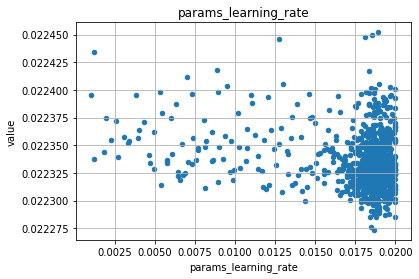

<Figure size 432x288 with 0 Axes>

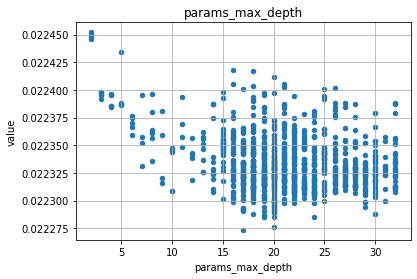

<Figure size 432x288 with 0 Axes>

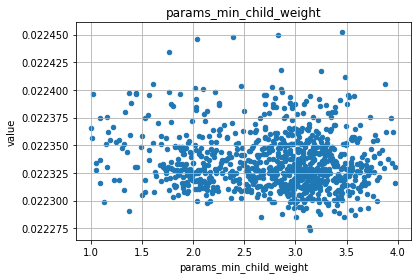

<Figure size 432x288 with 0 Axes>

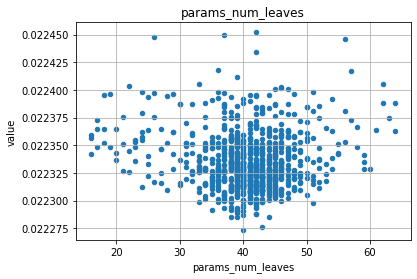

<Figure size 432x288 with 0 Axes>

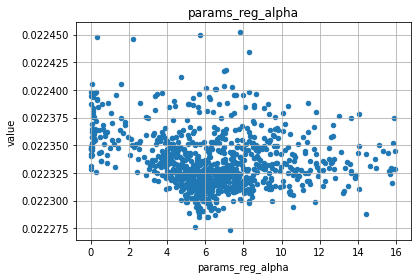

<Figure size 432x288 with 0 Axes>

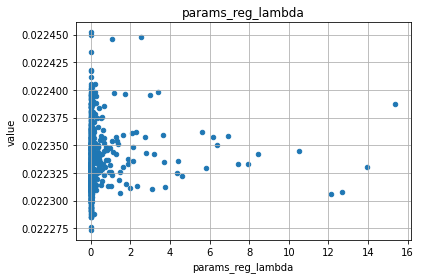

<Figure size 432x288 with 0 Axes>

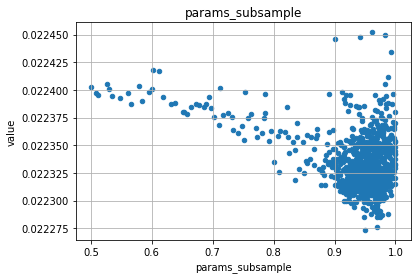

<Figure size 432x288 with 0 Axes>

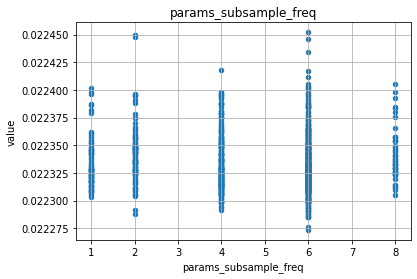

CPU times: user 1d 4h 38min 33s, sys: 7min 47s, total: 1d 4h 46min 21s
Wall time: 8h 2s


In [11]:
%%time
'''
Hyperparameter Optimization
'''
# run optimization
if RUN_HP_TUNE:
    best_params = optimize_hp()

# Refit best model

In [12]:
lgbm_var_params = best_params.copy()
lgbm_fixed_params = dict(
    objective = 'rmse',
    min_split_gain = 0,
    n_estimators = 5000,
    boosting_type = 'gbdt',
    n_jobs = -1,
    random_state = SEED,
    device_type = DEVICE_TYPE
)
params = (SELECTED_FEATS, lgbm_var_params, lgbm_fixed_params)

model_outputs = []
for fold in range(N_FOLD):
    model_outputs.append(train_model(fold, params, False))
    
cv_score = np.mean([x['best_score_'] for x in model_outputs])
cv_sharpe = np.mean([x['sharpe']['val'] for x in model_outputs])
log(f'CV score: {cv_score}')
log(f'CV sharpe: {cv_sharpe}')

[2022-06-01 06:08:20] CV score: 0.022308653104136638
[2022-06-01 06:08:20] CV sharpe: -0.06674088213897136
